In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
from IPython.display import display

#%matplotlib notebook


import sklearn
import matplotlib as mpl
import seaborn as sns

import re

%matplotlib inline

pd.options.display.max_rows = 10

In [2]:
# Dataset

train = pd.read_csv("data/train.zip", index_col=['id'])
test = pd.read_csv("data/test.zip", index_col=['id'])
sample_submission = pd.read_csv("data/sample_submission.zip", index_col=['id'])

print(train.shape, test.shape, sample_submission.shape)
print(set(train.columns) - set(test.columns))

(19579, 2) (8392, 1) (8392, 3)
{'author'}


In [3]:
train.head(5)

,text,author
id,,
id26305,"This process, however, afforded me no means of...",EAP
id17569,It never once occurred to me that the fumbling...,HPL
id11008,"In his left hand was a gold snuff box, from wh...",EAP
id27763,How lovely is spring As we looked from Windsor...,MWS
id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score

In [5]:
pipeline = Pipeline([
    ('features', CountVectorizer()),
    ('clf', LogisticRegression())
])

print('       score:', cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3))
print('neg_log_loss:', cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3, 
                      scoring='neg_log_loss'))

       score: [ 0.81449142  0.81673307  0.81348659]
neg_log_loss: [-0.47678328 -0.47558895 -0.47131481]


Ползването на cross_val_score изглежда зачиства резултатите от scope-а на pipeline:

In [6]:
from sklearn.exceptions import NotFittedError

count_vectorizer = pipeline.steps[0][1]
print(type(count_vectorizer))
try:
    count_vectorizer.vocabulary_
except (AttributeError, NotFittedError) as e:
    print(e)

<class 'sklearn.feature_extraction.text.CountVectorizer'>
'CountVectorizer' object has no attribute 'vocabulary_'


In [7]:
pipeline.fit(train.text, train.author)
count_vectorizer = pipeline.steps[0][1]
# count_vectorizer._validate_vocabulary()

In [8]:
list(count_vectorizer.vocabulary_.items())[:10]

[('this', 22175),
 ('process', 17139),
 ('however', 10784),
 ('afforded', 455),
 ('me', 13678),
 ('no', 14817),
 ('means', 13696),
 ('of', 15145),
 ('ascertaining', 1300),
 ('the', 22085)]

In [9]:
pd.set_option('display.float_format', '{:.2f}'.format)
slice_ = train.text[:10]
print('decision func:\n', pipeline.decision_function(slice_))
print('predict_proba:\n', np.round(pipeline.predict_proba(slice_),3))
print('predict :', pipeline.predict(slice_))
print('observed:', train.author.values[:10])

decision func:
 [[  6.88005027  -5.53085487  -8.55660704]
 [ -0.30598266  -0.0355784   -3.06925049]
 [  1.94575346  -1.73436774  -6.65837008]
 [ -6.24311246  -7.71766753   8.03335118]
 [ -1.08496043   0.50364988  -2.79939235]
 [ -4.47520353 -12.52733853   6.61040277]
 [  1.87293228  -1.83363116  -4.39112308]
 [  1.28128144  -2.76106269  -1.87615553]
 [  1.71256761  -4.20021945  -6.89789641]
 [ -1.54097308  -3.39287914   1.20978569]]
predict_proba:
 [[ 0.996  0.004  0.   ]
 [ 0.442  0.512  0.046]
 [ 0.853  0.146  0.001]
 [ 0.002  0.     0.998]
 [ 0.271  0.668  0.061]
 [ 0.011  0.     0.989]
 [ 0.852  0.136  0.012]
 [ 0.803  0.061  0.136]
 [ 0.982  0.017  0.001]
 [ 0.18   0.033  0.787]]
predict : ['EAP' 'HPL' 'EAP' 'MWS' 'HPL' 'MWS' 'EAP' 'EAP' 'EAP' 'MWS']
observed: ['EAP' 'HPL' 'EAP' 'MWS' 'HPL' 'MWS' 'EAP' 'EAP' 'EAP' 'MWS']


In [10]:
import itertools
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(9, 7)):
    matrix = confusion_matrix(y_true, y_pred)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 size=int((figsize[0] / 10) * 38),
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cross_val_predict != cross_val_score

In [11]:
from sklearn.model_selection import cross_val_predict

prediction = cross_val_predict(pipeline, train.text, train.author, cv=3, n_jobs=3)
prediction

array(['EAP', 'EAP', 'EAP', ..., 'EAP', 'EAP', 'HPL'], dtype=object)

Тази графика не дава информация за "увереността" на предположенията.

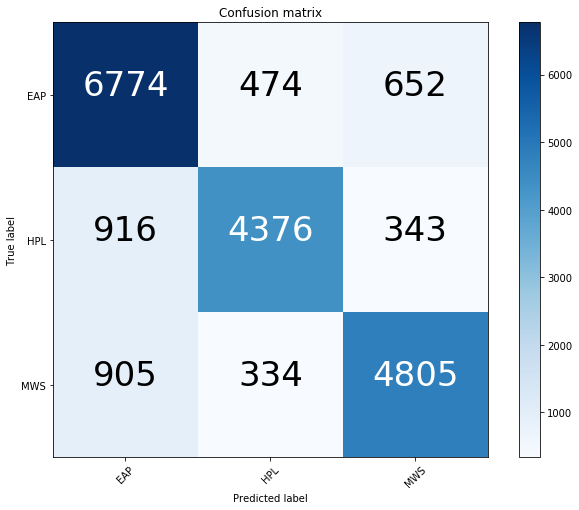

In [12]:
authors = pipeline.classes_
plot_confusion_matrix(train.author, prediction, classes=authors)

In [13]:
authors

array(['EAP', 'HPL', 'MWS'], dtype=object)

In [14]:
single_ = train.text.iloc[0]
single_

'This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.'

In [15]:
pipeline.predict_proba([single_])

array([[  9.95873648e-01,   3.93471446e-03,   1.91637189e-04]])

In [16]:
single_probas = [ [z] for z in pipeline.predict_proba([single_])[0]]
single_probas

[[0.99587364835336278], [0.0039347144572666644], [0.00019163718937051345]]

In [17]:
[train.author.iloc[0]]

['EAP']

In [18]:
log_loss([1], [[0.5, 0.3333333, 0.0416666]], labels=[1, 0, 3])

0.96508088175787132

In [19]:
log_loss(y_true=[['EAP']], y_pred=[[0.99587364835336278,
                                 0.0039347144572666644,
                                 0.00019163718937051345]],
         labels=['EAP', 'HPL', 'MWS'])

0.004134888527801966

In [20]:
log_loss(y_true=[['EAP']], y_pred=pipeline.predict_proba([single_]),
         labels=authors)
#          labels=['EAP', 'HPL', 'MWS'])

0.004134888527801966

In [21]:
print(authors.tolist())
print(len(pipeline.predict_proba(train.text)))
print([list(train.author[:10])])
pipeline.predict_proba(train.text[:10]).tolist()

['EAP', 'HPL', 'MWS']
19579
[['EAP', 'HPL', 'EAP', 'MWS', 'HPL', 'MWS', 'EAP', 'EAP', 'EAP', 'MWS']]


[[0.9958736483533628, 0.003934714457266664, 0.00019163718937051345],
 [0.441952460968289, 0.5117847030623977, 0.04626283596931342],
 [0.8525653352362134, 0.14618590817393715, 0.001248756589849516],
 [0.0019360361367847896, 0.000443784897841265, 0.9976201789653739],
 [0.27063549295615785, 0.6679045517400033, 0.0614599553038388],
 [0.011149094075245636, 3.590525052634117e-06, 0.9888473153997018],
 [0.8524431480124934, 0.13552421197831618, 0.012032640009190439],
 [0.8027660284042524, 0.06099190805150025, 0.1362420635442474],
 [0.9817141786573361, 0.0171167035418542, 0.0011691178008096696],
 [0.18014563931187963, 0.03321040363574766, 0.7866439570523727]]

In [22]:
log_loss(y_true=list(train.author[:10]),
         y_pred=pipeline.predict_proba(train.text[:10]).tolist(),
         labels=authors.tolist())

0.18884749191598543

In [23]:
log_loss(y_true=list(train.author),
         y_pred=pipeline.predict_proba(train.text).tolist(),
         labels=authors.tolist())

0.20227348134133219

import relog_loss няма специфична стойност за всяка клетка от confusion_matrix

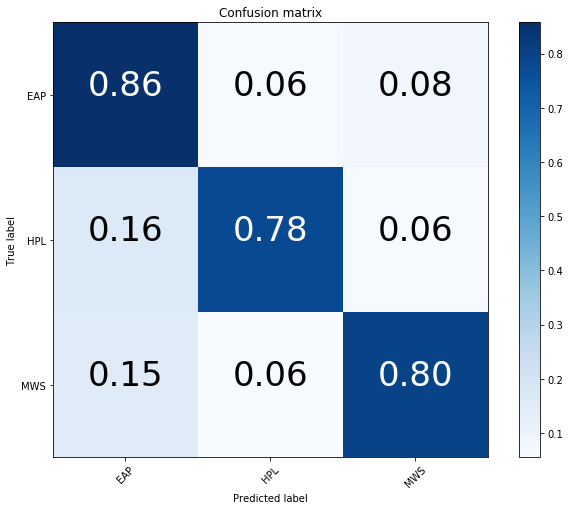

In [24]:
plot_confusion_matrix(train.author, prediction, classes=authors, normalize=True)

add som new features

In [41]:
explore = train.copy()

for name, char in {'question': '?', 'semicol': ';'}.items():
    explore[name] = explore.text.apply(lambda s: s.count(char))

explore[:10]

,text,author,question,semicol
id,,,,
id26305,"This process, however, afforded me no means of...",EAP,0,2
id17569,It never once occurred to me that the fumbling...,HPL,0,0
id11008,"In his left hand was a gold snuff box, from wh...",EAP,0,0
id27763,How lovely is spring As we looked from Windsor...,MWS,0,0
id12958,"Finding nothing else, not even gold, the Super...",HPL,0,1
id22965,"A youth passed in solitude, my best years spen...",MWS,0,0
id09674,"The astronomer, perhaps, at this point, took r...",EAP,0,1
id13515,The surcingle hung in ribands from my body.,EAP,0,0
id19322,I knew that you could not say to yourself 'ste...,EAP,0,1


In [42]:
print(explore.columns)
features_names = list(set(explore.columns) - {'text', 'author'})

Index(['text', 'author', 'question', 'semicol'], dtype='object')


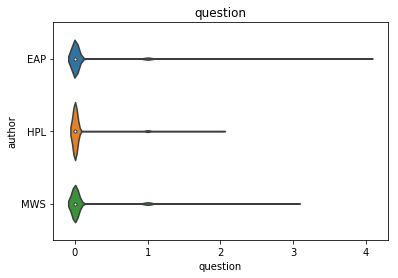

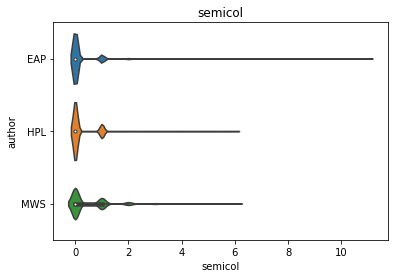

In [43]:
for feature in features_names:
    plt.figure()
    sns.violinplot(x=feature, y="author", data=explore)
    plt.title(feature);

In [46]:
from sklearn.svm import LinearSVC
cross_val_score(LinearSVC(), explore[features_names], explore.author, cv=3, n_jobs=1)

array([ 0.44623162,  0.44943304,  0.45011494])

In [47]:
explore[features_names].shape

(19579, 2)

In [48]:
explore.author.shape

(19579,)

In [44]:
print('       score:', cross_val_score(pipeline, explore[features_names], explore.author, cv=3, n_jobs=3))
print('neg_log_loss:', cross_val_score(pipeline, explore[features_names], explore.author, cv=3, n_jobs=3, 
                      scoring='neg_log_loss'))

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/usr/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7f89657821e0, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/bob/.local/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/bob/.local/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/bob/.l.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f89657821e0, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/bob/.local/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/bob/.local/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/bob/.l.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "print('       score:', cross_val_score(pipeline,..., \n                      scoring='neg_log_loss'))", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 11, 19, 18, 49, 30, 680824, tzinfo=tzutc()), 'msg_id': 'C28B5E647F674BF49EE6BA09A655D389', 'msg_type': 'execute_request', 'session': 'D6D94AF8F65B429CAF9748E4AD765F58', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'C28B5E647F674BF49EE6BA09A655D389', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'D6D94AF8F65B429CAF9748E4AD765F58']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "print('       score:', cross_val_score(pipeline,..., \n                      scoring='neg_log_loss'))", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 11, 19, 18, 49, 30, 680824, tzinfo=tzutc()), 'msg_id': 'C28B5E647F674BF49EE6BA09A655D389', 'msg_type': 'execute_request', 'session': 'D6D94AF8F65B429CAF9748E4AD765F58', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'C28B5E647F674BF49EE6BA09A655D389', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'D6D94AF8F65B429CAF9748E4AD765F58'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "print('       score:', cross_val_score(pipeline,..., \n                      scoring='neg_log_loss'))", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 11, 19, 18, 49, 30, 680824, tzinfo=tzutc()), 'msg_id': 'C28B5E647F674BF49EE6BA09A655D389', 'msg_type': 'execute_request', 'session': 'D6D94AF8F65B429CAF9748E4AD765F58', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'C28B5E647F674BF49EE6BA09A655D389', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="print('       score:', cross_val_score(pipeline,..., \n                      scoring='neg_log_loss'))", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "print('       score:', cross_val_score(pipeline,..., \n                      scoring='neg_log_loss'))"
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("print('       score:', cross_val_score(pipeline,..., \n                      scoring='neg_log_loss'))",), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("print('       score:', cross_val_score(pipeline,..., \n                      scoring='neg_log_loss'))",)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="print('       score:', cross_val_score(pipeline,..., \n                      scoring='neg_log_loss'))", store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>, <_ast.Expr object>], cell_name='<ipython-input-44-8470f507ecd1>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f89203a8240, executi..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f8923c548a0, file "<ipython-input-44-8470f507ecd1>", line 1>
        result = <ExecutionResult object at 7f89203a8240, executi..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f8923c548a0, file "<ipython-input-44-8470f507ecd1>", line 1>, result=<ExecutionResult object at 7f89203a8240, executi..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f8923c548a0, file "<ipython-input-44-8470f507ecd1>", line 1>
        self.user_global_ns = {'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'In': ['', "import numpy as np\nimport matplotlib.pyplot as p...lib', 'inline')\n\npd.options.display.max_rows = 10", '# Dataset\n\ntrain = pd.read_csv("data/train.zip",...pe)\nprint(set(train.columns) - set(test.columns))', 'train.head(5)', 'from sklearn.pipeline import Pipeline\nfrom sklea...om sklearn.model_selection import cross_val_score', "pipeline = Pipeline([\n    ('features', CountVect..., \n                      scoring='neg_log_loss'))", 'from sklearn.exceptions import NotFittedError\n\nc...ttributeError, NotFittedError) as e:\n    print(e)', 'pipeline.fit(train.text, train.author)\ncount_vec...s[0][1]\n# count_vectorizer._validate_vocabulary()', 'list(count_vectorizer.vocabulary_.items())[:10]', "pd.set_option('display.float_format', '{:.2f}'.f...e_))\nprint('observed:', train.author.values[:10])", "import itertools\nfrom sklearn.metrics import con...l('True label')\n    plt.xlabel('Predicted label')", 'from sklearn.model_selection import cross_val_pr...in.text, train.author, cv=3, n_jobs=3)\nprediction', 'authors = pipeline.classes_\nplot_confusion_matrix(train.author, prediction, classes=authors)', 'authors', 'single_ = train.text.iloc[0]\nsingle_', 'pipeline.predict_proba([single_])', 'single_probas = [ [z] for z in pipeline.predict_proba([single_])[0]]\nsingle_probas', '[train.author.iloc[0]]', 'log_loss([1], [[0.5, 0.3333333, 0.0416666]], labels=[1, 0, 3])', "log_loss(y_true=[['EAP']], y_pred=[[0.9958736483...7051345]],\n         labels=['EAP', 'HPL', 'MWS'])", ...], 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'NotFittedError': <class 'sklearn.exceptions.NotFittedError'>, 'Out': {3:                                                 ... nothing else, not even gold, the Super...    HPL, 8: [('this', 22175), ('process', 17139), ('however', 10784), ('afforded', 455), ('me', 13678), ('no', 14817), ('means', 13696), ('of', 15145), ('ascertaining', 1300), ('the', 22085)], 11: array(['EAP', 'EAP', 'EAP', ..., 'EAP', 'EAP', 'HPL'], dtype=object), 13: array(['EAP', 'HPL', 'MWS'], dtype=object), 14: 'This process, however, afforded me no means of a...f the fact; so perfectly uniform seemed the wall.', 15: array([[  9.95873648e-01,   3.93471446e-03,   1.91637189e-04]]), 16: [[0.99587364835336278], [0.0039347144572666644], [0.00019163718937051345]], 17: ['EAP'], 18: 0.96508088175787132, 19: 0.004134888527801966, ...}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, '_':                                                 ...        0  
id19322        1  
id00912        0  , '_11': array(['EAP', 'EAP', 'EAP', ..., 'EAP', 'EAP', 'HPL'], dtype=object), '_13': array(['EAP', 'HPL', 'MWS'], dtype=object), '_14': 'This process, however, afforded me no means of a...f the fact; so perfectly uniform seemed the wall.', ...}
        self.user_ns = {'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'In': ['', "import numpy as np\nimport matplotlib.pyplot as p...lib', 'inline')\n\npd.options.display.max_rows = 10", '# Dataset\n\ntrain = pd.read_csv("data/train.zip",...pe)\nprint(set(train.columns) - set(test.columns))', 'train.head(5)', 'from sklearn.pipeline import Pipeline\nfrom sklea...om sklearn.model_selection import cross_val_score', "pipeline = Pipeline([\n    ('features', CountVect..., \n                      scoring='neg_log_loss'))", 'from sklearn.exceptions import NotFittedError\n\nc...ttributeError, NotFittedError) as e:\n    print(e)', 'pipeline.fit(train.text, train.author)\ncount_vec...s[0][1]\n# count_vectorizer._validate_vocabulary()', 'list(count_vectorizer.vocabulary_.items())[:10]', "pd.set_option('display.float_format', '{:.2f}'.f...e_))\nprint('observed:', train.author.values[:10])", "import itertools\nfrom sklearn.metrics import con...l('True label')\n    plt.xlabel('Predicted label')", 'from sklearn.model_selection import cross_val_pr...in.text, train.author, cv=3, n_jobs=3)\nprediction', 'authors = pipeline.classes_\nplot_confusion_matrix(train.author, prediction, classes=authors)', 'authors', 'single_ = train.text.iloc[0]\nsingle_', 'pipeline.predict_proba([single_])', 'single_probas = [ [z] for z in pipeline.predict_proba([single_])[0]]\nsingle_probas', '[train.author.iloc[0]]', 'log_loss([1], [[0.5, 0.3333333, 0.0416666]], labels=[1, 0, 3])', "log_loss(y_true=[['EAP']], y_pred=[[0.9958736483...7051345]],\n         labels=['EAP', 'HPL', 'MWS'])", ...], 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'NotFittedError': <class 'sklearn.exceptions.NotFittedError'>, 'Out': {3:                                                 ... nothing else, not even gold, the Super...    HPL, 8: [('this', 22175), ('process', 17139), ('however', 10784), ('afforded', 455), ('me', 13678), ('no', 14817), ('means', 13696), ('of', 15145), ('ascertaining', 1300), ('the', 22085)], 11: array(['EAP', 'EAP', 'EAP', ..., 'EAP', 'EAP', 'HPL'], dtype=object), 13: array(['EAP', 'HPL', 'MWS'], dtype=object), 14: 'This process, however, afforded me no means of a...f the fact; so perfectly uniform seemed the wall.', 15: array([[  9.95873648e-01,   3.93471446e-03,   1.91637189e-04]]), 16: [[0.99587364835336278], [0.0039347144572666644], [0.00019163718937051345]], 17: ['EAP'], 18: 0.96508088175787132, 19: 0.004134888527801966, ...}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, '_':                                                 ...        0  
id19322        1  
id00912        0  , '_11': array(['EAP', 'EAP', 'EAP', ..., 'EAP', 'EAP', 'HPL'], dtype=object), '_13': array(['EAP', 'HPL', 'MWS'], dtype=object), '_14': 'This process, however, afforded me no means of a...f the fact; so perfectly uniform seemed the wall.', ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/home/bob/gits/spooky/<ipython-input-44-8470f507ecd1> in <module>()
----> 1 print('       score:', cross_val_score(pipeline, explore[features_names], explore.author, cv=3, n_jobs=3))
      2 print('neg_log_loss:', cross_val_score(pipeline, explore[features_names], explore.author, cv=3, n_jobs=3, 
      3                       scoring='neg_log_loss'))

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in cross_val_score(estimator=Pipeline(memory=None,
     steps=[('features', C...0.0001,
          verbose=0, warm_start=False))]), X=         question  semicol
id                   ...0393         0        0

[19579 rows x 2 columns], y=id
id26305    EAP
id17569    HPL
id11008    EAP
...   HPL
Name: author, Length: 19579, dtype: object, groups=None, scoring=None, cv=3, n_jobs=3, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')
    337     cv_results = cross_validate(estimator=estimator, X=X, y=y, groups=groups,
    338                                 scoring={'score': scorer}, cv=cv,
    339                                 return_train_score=False,
    340                                 n_jobs=n_jobs, verbose=verbose,
    341                                 fit_params=fit_params,
--> 342                                 pre_dispatch=pre_dispatch)
        pre_dispatch = '2*n_jobs'
    343     return cv_results['test_score']
    344 
    345 
    346 def _fit_and_score(estimator, X, y, scorer, train, test, verbose,

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in cross_validate(estimator=Pipeline(memory=None,
     steps=[('features', C...0.0001,
          verbose=0, warm_start=False))]), X=         question  semicol
id                   ...0393         0        0

[19579 rows x 2 columns], y=id
id26305    EAP
id17569    HPL
id11008    EAP
...   HPL
Name: author, Length: 19579, dtype: object, groups=None, scoring={'score': <function _passthrough_scorer>}, cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False), n_jobs=3, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', return_train_score=False)
    201     scores = parallel(
    202         delayed(_fit_and_score)(
    203             clone(estimator), X, y, scorers, train, test, verbose, None,
    204             fit_params, return_train_score=return_train_score,
    205             return_times=True)
--> 206         for train, test in cv.split(X, y, groups))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=3, random_state=None, shuffle=False)>
        X =          question  semicol
id                   ...0393         0        0

[19579 rows x 2 columns]
        y = id
id26305    EAP
id17569    HPL
id11008    EAP
...   HPL
Name: author, Length: 19579, dtype: object
        groups = None
    207 
    208     if return_train_score:
    209         train_scores, test_scores, fit_times, score_times = zip(*scores)
    210         train_scores = _aggregate_score_dicts(train_scores)

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=3), iterable=<generator object cross_validate.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=3)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sun Nov 19 10:49:30 2017
PID: 3748                                    Python 3.6.3: /usr/bin/python3
...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(memory=None,
     steps=[('features', C...0.0001,
          verbose=0, warm_start=False))]),          question  semicol
id                   ...0393         0        0

[19579 rows x 2 columns], id
id26305    EAP
id17569    HPL
id11008    EAP
...   HPL
Name: author, Length: 19579, dtype: object, {'score': <function _passthrough_scorer>}, array([ 6475,  6476,  6478, ..., 19576, 19577, 19578]), array([   0,    1,    2, ..., 6604, 6605, 6606]), 0, None, None), {'return_times': True, 'return_train_score': False})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(memory=None,
     steps=[('features', C...0.0001,
          verbose=0, warm_start=False))]),          question  semicol
id                   ...0393         0        0

[19579 rows x 2 columns], id
id26305    EAP
id17569    HPL
id11008    EAP
...   HPL
Name: author, Length: 19579, dtype: object, {'score': <function _passthrough_scorer>}, array([ 6475,  6476,  6478, ..., 19576, 19577, 19578]), array([   0,    1,    2, ..., 6604, 6605, 6606]), 0, None, None)
        kwargs = {'return_times': True, 'return_train_score': False}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Pipeline(memory=None,
     steps=[('features', C...0.0001,
          verbose=0, warm_start=False))]), X=         question  semicol
id                   ...0393         0        0

[19579 rows x 2 columns], y=id
id26305    EAP
id17569    HPL
id11008    EAP
...   HPL
Name: author, Length: 19579, dtype: object, scorer={'score': <function _passthrough_scorer>}, train=array([ 6475,  6476,  6478, ..., 19576, 19577, 19578]), test=array([   0,    1,    2, ..., 6604, 6605, 6606]), verbose=0, parameters=None, fit_params={}, return_train_score=False, return_parameters=False, return_n_test_samples=False, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method Pipeline.fit of Pipeline(memory=No....0001,
          verbose=0, warm_start=False))])>
        X_train =          question  semicol
id                   ...0393         0        0

[13051 rows x 2 columns]
        y_train = id
id15739    EAP
id19588    EAP
id11059    EAP
...   HPL
Name: author, Length: 13051, dtype: object
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/pipeline.py in fit(self=Pipeline(memory=None,
     steps=[('features', C...0.0001,
          verbose=0, warm_start=False))]), X=         question  semicol
id                   ...0393         0        0

[13051 rows x 2 columns], y=id
id15739    EAP
id19588    EAP
id11059    EAP
...   HPL
Name: author, Length: 13051, dtype: object, **fit_params={})
    245         self : Pipeline
    246             This estimator
    247         """
    248         Xt, fit_params = self._fit(X, y, **fit_params)
    249         if self._final_estimator is not None:
--> 250             self._final_estimator.fit(Xt, y, **fit_params)
        self._final_estimator.fit = <bound method LogisticRegression.fit of Logistic...l=0.0001,
          verbose=0, warm_start=False)>
        Xt = <2x2 sparse matrix of type '<class 'numpy.int64'... stored elements in Compressed Sparse Row format>
        y = id
id15739    EAP
id19588    EAP
id11059    EAP
...   HPL
Name: author, Length: 13051, dtype: object
        fit_params = {}
    251         return self
    252 
    253     def fit_transform(self, X, y=None, **fit_params):
    254         """Fit the model and transform with the final estimator

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py in fit(self=LogisticRegression(C=1.0, class_weight=None, dua...ol=0.0001,
          verbose=0, warm_start=False), X=<2x2 sparse matrix of type '<class 'numpy.int64'... stored elements in Compressed Sparse Row format>, y=id
id15739    EAP
id19588    EAP
id11059    EAP
...   HPL
Name: author, Length: 13051, dtype: object, sample_weight=None)
   1211             _dtype = [np.float64, np.float32]
   1212         else:
   1213             _dtype = np.float64
   1214 
   1215         X, y = check_X_y(X, y, accept_sparse='csr', dtype=_dtype,
-> 1216                          order="C")
   1217         check_classification_targets(y)
   1218         self.classes_ = np.unique(y)
   1219         n_samples, n_features = X.shape
   1220 

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/utils/validation.py in check_X_y(X=<2x2 sparse matrix of type '<class 'numpy.float6... stored elements in Compressed Sparse Row format>, y=array(['EAP', 'EAP', 'EAP', ..., 'EAP', 'EAP', 'HPL'], dtype=object), accept_sparse='csr', dtype=<class 'numpy.float64'>, order='C', copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, multi_output=False, ensure_min_samples=1, ensure_min_features=1, y_numeric=False, warn_on_dtype=False, estimator=None)
    578         y = column_or_1d(y, warn=True)
    579         _assert_all_finite(y)
    580     if y_numeric and y.dtype.kind == 'O':
    581         y = y.astype(np.float64)
    582 
--> 583     check_consistent_length(X, y)
        X = <2x2 sparse matrix of type '<class 'numpy.float6... stored elements in Compressed Sparse Row format>
        y = array(['EAP', 'EAP', 'EAP', ..., 'EAP', 'EAP', 'HPL'], dtype=object)
    584 
    585     return X, y
    586 
    587 

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/utils/validation.py in check_consistent_length(*arrays=(<2x2 sparse matrix of type '<class 'numpy.float6... stored elements in Compressed Sparse Row format>, array(['EAP', 'EAP', 'EAP', ..., 'EAP', 'EAP', 'HPL'], dtype=object)))
    199 
    200     lengths = [_num_samples(X) for X in arrays if X is not None]
    201     uniques = np.unique(lengths)
    202     if len(uniques) > 1:
    203         raise ValueError("Found input variables with inconsistent numbers of"
--> 204                          " samples: %r" % [int(l) for l in lengths])
        lengths = [2, 13051]
    205 
    206 
    207 def indexable(*iterables):
    208     """Make arrays indexable for cross-validation.

ValueError: Found input variables with inconsistent numbers of samples: [2, 13051]
___________________________________________________________________________

In [25]:
# %reset

In [26]:
# import re
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd

# from IPython.display import display
# # import sklearn
# from sklearn.pipeline import Pipeline
# from sklearn.linear_model import LogisticRegression
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.model_selection import cross_val_score

# # import seaborn as sns
# # import mglearn

# #%matplotlib notebook
# %matplotlib inline

# pd.options.display.max_rows = 10

In [ ]:
# train = pd.read_csv("data/train.zip", index_col=['id'])
# test = pd.read_csv("data/test.zip", index_col=['id'])
# print(train.text.shape)

In [27]:
# # cv = CountVectorizer()
# # cv.fit(train.text)
# # print(list(cv.vocabulary_.items())[:10])

In [28]:
fail here

SyntaxError: invalid syntax (<ipython-input-28-a2f04ec58aab>, line 1)

In [33]:
cv = CountVectorizer()
tmp = cv.fit_transform(train.text)#.todense()
transformed = pd.DataFrame(tmp, columns=cv.vocabulary_.keys())

ValueError: DataFrame constructor not properly called!

In [31]:
for char in list('?!;'):
    transformed[char] = train.text.apply(lambda s: s.count(char))

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [ ]:
transformed

In [ ]:
print('       score:', cross_val_score(pipeline, train[['text', '?', '!', ';']], train.author, cv=3, n_jobs=3))
# print('neg_log_loss:', cross_val_score(pipeline, train[['text', '?', '!', ';']], train.author, cv=3, n_jobs=3, 
#                       scoring='neg_log_loss'))

In [ ]:
cv = CountVectorizer().fit(train.text)
cv.vocabulary_
# transformed = cv.transform(train.text)
# transformed.todense()

In [ ]:
lr = LogisticRegression().fit(train[['text', '?', '!', ';']], train.author)

In [ ]:
print(train.text.loc['id26305'], train.author.loc['id26305'])